#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
# pip install keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import *


# import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


* 함수 생성

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [5]:
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [6]:
path = '/content/drive/MyDrive/deep_learning/MP3/'
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [7]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [8]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [9]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [11]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [12]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [13]:
target = 'Activity'
data[target] = data[target].map({'STANDING':0, 'SITTING':1, 'LAYING':2,
                  'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})
x = data.drop(target, axis=1)
y = data[target]

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [14]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2023)
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_s, y, test_size = .2, random_state = 2023)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : RandomForest Classifier

In [16]:
m1_1 = RandomForestClassifier()

m1_1.fit(x_train, y_train)
p1_1 = m1_1.predict(x_val)

print('accuracy :',accuracy_score(y_val, p1_1))
print('='*60)
print(confusion_matrix(y_val, p1_1))
print('='*60)
print(classification_report(y_val, p1_1))

accuracy : 0.9796091758708582
[[215   3   0   0   0   0]
 [ 14 195   0   0   0   0]
 [  0   0 230   0   0   0]
 [  0   0   0 175   2   3]
 [  0   0   0   0 175   0]
 [  0   0   0   1   1 163]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       218
           1       0.98      0.93      0.96       209
           2       1.00      1.00      1.00       230
           3       0.99      0.97      0.98       180
           4       0.98      1.00      0.99       175
           5       0.98      0.99      0.98       165

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [17]:
r = plot_feature_importance(m1_1.feature_importances_, list(x_train), True)

In [18]:
r.head()

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.035866
1,"angle(X,gravityMean)",0.032284
2,tGravityAcc-min()-X,0.031994
3,tGravityAcc-max()-X,0.031133
4,tGravityAcc-energy()-X,0.029898


In [19]:
result = pd.DataFrame({'algorithm':[],'accuracy':[]})
acc = accuracy_score(y_val, p1_1)
row = ['rf', acc]
result.loc[0] = row
result.head()

,algorithm,accuracy
0,rf,0.979609


# 적절한 변수 n개 선택

In [20]:
feature100 = r.loc[:50, 'feature_name']

In [21]:
x_train100 = x_train[feature100]
x_val100 = x_val[feature100]

In [22]:
m1_2 = RandomForestClassifier()

m1_2.fit(x_train100, y_train)
p1_2 = m1_2.predict(x_val100)

print('accuracy :',accuracy_score(y_val, p1_2))
print('='*60)
print(confusion_matrix(y_val, p1_2))
print('='*60)
print(classification_report(y_val, p1_2))

accuracy : 0.9753610875106202
[[209   9   0   0   0   0]
 [  6 203   0   0   0   0]
 [  0   0 230   0   0   0]
 [  0   0   0 174   2   4]
 [  0   0   0   1 173   1]
 [  0   0   0   4   2 159]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       218
           1       0.96      0.97      0.96       209
           2       1.00      1.00      1.00       230
           3       0.97      0.97      0.97       180
           4       0.98      0.99      0.98       175
           5       0.97      0.96      0.97       165

    accuracy                           0.98      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.98      0.98      0.98      1177



### (2) 알고리즘2 : Logistic Regression

In [23]:
m2_1 = LogisticRegression()

m2_1.fit(x_train, y_train)
p2_1 = m1_1.predict(x_val)

print('accuracy :',accuracy_score(y_val, p2_1))
print('='*60)
print(confusion_matrix(y_val, p2_1))
print('='*60)
print(classification_report(y_val, p2_1))

accuracy : 0.9796091758708582
[[215   3   0   0   0   0]
 [ 14 195   0   0   0   0]
 [  0   0 230   0   0   0]
 [  0   0   0 175   2   3]
 [  0   0   0   0 175   0]
 [  0   0   0   1   1 163]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       218
           1       0.98      0.93      0.96       209
           2       1.00      1.00      1.00       230
           3       0.99      0.97      0.98       180
           4       0.98      1.00      0.99       175
           5       0.98      0.99      0.98       165

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
acc = accuracy_score(y_val, p2_1)
row = ['lr', acc]
result.loc[1] = row
result.head()

,algorithm,accuracy
0,rf,0.979609
1,lr,0.979609


### (3) 알고리즘3 : XGB Classifier

In [25]:
#매개변수 C, gamma, kernel 모두 기본값
m3_1 = XGBClassifier()
m3_1.fit(x_train, y_train)
p3_1 = m3_1.predict(x_val)

print('accuracy :',accuracy_score(y_val, p3_1))
print('='*60)
print(confusion_matrix(y_val, p3_1))
print('='*60)
print(classification_report(y_val, p3_1))

accuracy : 0.9923534409515717
[[217   1   0   0   0   0]
 [  6 203   0   0   0   0]
 [  0   0 230   0   0   0]
 [  0   0   0 179   0   1]
 [  0   0   0   1 174   0]
 [  0   0   0   0   0 165]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       218
           1       1.00      0.97      0.98       209
           2       1.00      1.00      1.00       230
           3       0.99      0.99      0.99       180
           4       1.00      0.99      1.00       175
           5       0.99      1.00      1.00       165

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [26]:
r3 = plot_feature_importance(m3_1.feature_importances_, list(x_train), True)
r3.head()

,feature_name,feature_importance
0,fBodyAcc-skewness()-X,0.086745
1,"angle(Y,gravityMean)",0.076878
2,"angle(X,gravityMean)",0.070547
3,tGravityAcc-energy()-X,0.061589
4,fBodyAccMag-mad(),0.060068


In [27]:
acc = accuracy_score(y_val, p3_1)
row = ['xgb', acc]
result.loc[2] = row
result.head()

,algorithm,accuracy
0,rf,0.979609
1,lr,0.979609
2,xgb,0.992353


### (4) 알고리즘4 : LGBM Classifier

In [28]:
import re
x_train_lgbm = x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [29]:
#매개변수 C, gamma, kernel 모두 기본값
m4_1 = LGBMClassifier()
m4_1.fit(x_train_lgbm, y_train)
p4_1 = m4_1.predict(x_val)

print('accuracy :',accuracy_score(y_val, p4_1))
print('='*60)
print(confusion_matrix(y_val, p4_1))
print('='*60)
print(classification_report(y_val, p4_1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140146
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.743212
[LightGBM] [Info] Start training from score -1.670581
[LightGBM] [Info] Start training from score -1.749306
[LightGBM] [Info] Start training from score -1.929674
[LightGBM] [Info] Start training from score -2.016818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [30]:
r4 = plot_feature_importance(m4_1.feature_importances_, list(x_train), True)
r4.head()

,feature_name,feature_importance
0,tGravityAcc-min()-Y,418
1,tGravityAcc-energy()-Y,413
2,"tBodyAcc-correlation()-X,Y",293
3,tGravityAcc-max()-Y,271
4,tGravityAcc-mean()-X,250


In [31]:
acc = accuracy_score(y_val, p4_1)
row = ['lgbm', acc]
result.loc[3] = row
result.head()

,algorithm,accuracy
0,rf,0.979609
1,lr,0.979609
2,xgb,0.992353
3,lgbm,0.993203


# 딥러닝

# 모델 1

In [32]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

In [33]:
x_train_s.shape

(4704, 561)

In [34]:
clear_session()
# 모델링
nfeatures=561
m5_1 = Sequential(
   [ Dense(512, input_shape = (nfeatures,), activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(6, activation = 'softmax') ]
    )

# 요약
m5_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               287744    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 460614 (1.76 MB)
Trainable params: 460614 (1.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
m5_1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history = m5_1.fit(x_train_s, y_train, epochs = 50, validation_split=0.2).history

Epoch 1/50
118/118 [==============================] - 3s 12ms/step - loss: 0.6063 - val_loss: 0.2961
Epoch 2/50
118/118 [==============================] - 2s 13ms/step - loss: 0.2450 - val_loss: 0.1528
Epoch 3/50
118/118 [==============================] - 2s 16ms/step - loss: 0.1790 - val_loss: 0.1346
Epoch 4/50
118/118 [==============================] - 2s 14ms/step - loss: 0.1350 - val_loss: 0.2296
Epoch 5/50
118/118 [==============================] - 1s 11ms/step - loss: 0.1248 - val_loss: 0.1722
Epoch 6/50
118/118 [==============================] - 1s 10ms/step - loss: 0.1281 - val_loss: 0.1182
Epoch 7/50
118/118 [==============================] - 1s 11ms/step - loss: 0.0917 - val_loss: 0.0729
Epoch 8/50
118/118 [==============================] - 1s 10ms/step - loss: 0.1241 - val_loss: 0.0759
Epoch 9/50
118/118 [==============================] - 1s 10ms/step - loss: 0.0964 - val_loss: 0.0708
Epoch 10/50
118/118 [==============================] - 1s 10ms/step - loss: 0.0882 - val_lo

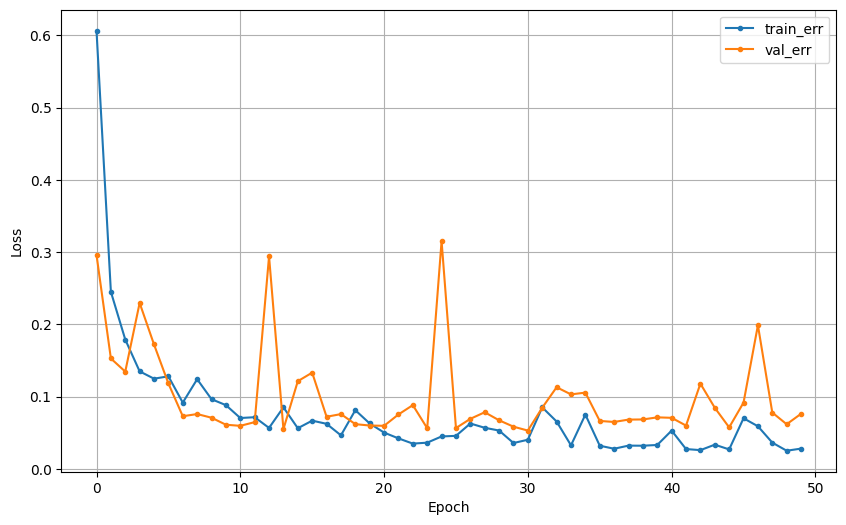

In [36]:
# 학습결과 확인
dl_history_plot(history)

In [37]:
# 예측
p5_1 = m5_1.predict(x_val_s)
p5_1[:5]

37/37 [==============================] - 0s 4ms/step


array([[3.06502557e-08, 1.64826944e-10, 4.81443285e-09, 9.99998033e-01,
        1.19677679e-06, 6.84475822e-07],
       [9.99058664e-01, 9.18727659e-04, 7.69896178e-06, 1.04963219e-05,
        1.73123999e-06, 2.56824137e-06],
       [1.33886122e-17, 7.60506824e-10, 9.99999940e-01, 5.45680124e-12,
        1.95231664e-17, 3.85901759e-18],
       [1.02456885e-04, 9.99875069e-01, 1.99528840e-05, 4.54388882e-08,
        2.64446112e-06, 2.15159481e-08],
       [1.00314560e-20, 4.36778299e-13, 9.99999940e-01, 4.14683174e-14,
        1.25253663e-21, 5.28783688e-22]], dtype=float32)

In [38]:
p5_1 = np.argmax(p5_1, axis = 1)

In [39]:
# 평가
print(accuracy_score(y_val, p5_1))
print(confusion_matrix(y_val, p5_1))
print(classification_report(y_val, p5_1))

0.9745114698385726
[[196  22   0   0   0   0]
 [  4 204   0   1   0   0]
 [  0   0 230   0   0   0]
 [  0   0   0 180   0   0]
 [  0   0   0   3 172   0]
 [  0   0   0   0   0 165]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       218
           1       0.90      0.98      0.94       209
           2       1.00      1.00      1.00       230
           3       0.98      1.00      0.99       180
           4       1.00      0.98      0.99       175
           5       1.00      1.00      1.00       165

    accuracy                           0.97      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.97      0.97      1177



In [40]:
acc = accuracy_score(y_val, p5_1)
row = ['dl', acc]
result.loc[4] = row
result.head()

,algorithm,accuracy
0,rf,0.979609
1,lr,0.979609
2,xgb,0.992353
3,lgbm,0.993203
4,dl,0.974511


In [41]:
result.sort_values(by='accuracy', ascending=False, inplace=True)
result

,algorithm,accuracy
3,lgbm,0.993203
2,xgb,0.992353
0,rf,0.979609
1,lr,0.979609
4,dl,0.974511


In [46]:
fi_list = [r, r3, r4]
for x in fi_list:
  print(x.head(10))

             feature_name  feature_importance
0    tGravityAcc-mean()-X            0.035866
1    angle(X,gravityMean)            0.032284
2     tGravityAcc-min()-X            0.031994
3     tGravityAcc-max()-X            0.031133
4  tGravityAcc-energy()-X            0.029898
5     tGravityAcc-max()-Y            0.025600
6    angle(Y,gravityMean)            0.023664
7     tGravityAcc-min()-Y            0.023535
8    tGravityAcc-mean()-Y            0.023056
9  tGravityAcc-energy()-Y            0.013511
                   feature_name  feature_importance
0         fBodyAcc-skewness()-X            0.086745
1          angle(Y,gravityMean)            0.076878
2          angle(X,gravityMean)            0.070547
3        tGravityAcc-energy()-X            0.061589
4             fBodyAccMag-mad()            0.060068
5  fBodyAcc-bandsEnergy()-1,8.2            0.035269
6             fBodyAccMag-std()            0.033569
7          fBodyAccJerk-max()-Z            0.030873
8         tBodyGyroJerk-ma